In [1]:
import warnings
warnings.filterwarnings("ignore")

import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# https://sdv.dev/SDV/user_guides/single_table/ctgan.html
from ctgan import CTGANSynthesizer
from sklearn.base import BaseEstimator, TransformerMixin

MODELS_PATH = './models'
DATA_PATH = './data/'
dataset = 'adult'
seed = 1
np.random.seed(seed)

In [2]:
class ColumnsSelector(BaseEstimator, TransformerMixin):
  
    def __init__(self, type):
        print("ColumnsSelector init")
        self.type = type
  
    def fit(self, X, y=None):
        print("ColumnsSelector fit")
        return self

    def transform(self, X):
        print("ColumnsSelector transofrm")
        return X.select_dtypes(include=[self.type])

class CategoricalEncoder(BaseEstimator, TransformerMixin):
  
    def __init__(self, dropFirst=True):
        print("CategoricalEncoder init")
        self.categories = dict()
        self.dropFirst = dropFirst
    
    def fit(self, X, y=None):
        print("CategoricalEncoder fit")
        join_df = pd.concat([train_data, test_data])
        join_df = join_df.select_dtypes(include=['object'])
        for column in join_df.columns:
            self.categories[column] = join_df[column].value_counts().index.tolist()
        return self
    
    def transform(self, X):
        print("CategoricalEncoder transform")
        X_copy = X.copy()
        X_copy = X_copy.select_dtypes(include=['object'])
        for column in X_copy.columns:
            X_copy[column] = X_copy[column].astype({column: CategoricalDtype(self.categories[column])})
        return pd.get_dummies(X_copy, drop_first=self.dropFirst)

class CategoricalImputer(BaseEstimator, TransformerMixin):
  
    def __init__(self, columns = None, strategy='most_frequent'):
        print("CategoricalImputer init")
        self.columns = columns
        self.strategy = strategy
    
    def fit(self, X, y=None):
        print("CategoricalImputer fit")
        if self.columns is None:
            self.columns = X.columns

        if self.strategy is 'most_frequent':
            self.fill = {column: X[column].value_counts().index[0] for 
            column in self.columns}
        else:
            self.fill = {column: '0' for column in self.columns}

        return self
      
    def transform(self,X):
        print("CategoricalImputer transform")
        X_copy = X.copy()
        for column in self.columns:
            X_copy[column] = X_copy[column].fillna(self.fill[column])
        return X_copy

In [3]:
# load adult
# https://towardsdatascience.com/logistic-regression-classifier-on-census-income-data-e1dbef0b5738
def load_adult():
    columns = ["age",
               "workClass", 
               "fnlwgt", 
               "education", 
               "education-num",
               "marital-status", 
               "occupation", 
               "relationship",
               "race", 
               "sex", 
               "capital-gain", 
               "capital-loss",
               "hours-per-week", 
               "native-country", 
               "income"]
    
    train = pd.read_csv(os.path.join(DATA_PATH, 'adult/data'), names=columns, sep=' *, *', na_values='?', engine='python')
    test = pd.read_csv(os.path.join(DATA_PATH, 'adult/test'), names=columns, sep=' *, *', skiprows=1, na_values='?', engine='python')

#     test['income'].replace(regex=True, inplace=True, to_replace=r'\.', value=r'')
#     adult = pd.concat([test,train])
#     adult.reset_index(inplace=True, drop=True)
#     return adult,
    return train, test, columns

In [4]:
train_data, test_data, discrete_columns = load_adult()    

In [9]:
train_data.shape

(32561, 15)

# Train CTGAN with confidence level and black-box model

### CTGAN code structure:
1. **transformer.py** - implements _Mode-specific Normalization_ to continuous values, while categorical are encoded with OHE.

2. **synthesizer.py** - main code, implements fit (training GAN), predict (sample data), save and load. 

3. **models.py** - file contains Discriminator, Generator and Residual models.

4. **sampler.py** - TODO

5. **conditional.py** - TODO

In [5]:
# load rf model
with open(os.path.join(MODELS_PATH, 'adult_rf_0.852.pkl'), 'rb') as rf_fd:
    rf_model = pickle.load(rf_fd)
    
# load rf pipeline
with open(os.path.join(MODELS_PATH, 'adult_rf_0.852_pipeline.pkl'), 'rb') as pl_fd:
    rf_pipeline = pickle.load(pl_fd)

In [6]:
def gen_random_noise(shape):
    mu = 0
    sigma = 1
    z = sigma * np.random.randn(*shape) + mu
    return pd.DataFrame(z)

In [7]:
z = gen_random_noise(shape=(10000, 81))

rf_ctgan = CTGANSynthesizer(batch_size=500, 
                            blackbox_model=rf_model, 
                            preprocessing_pipeline=rf_pipeline, 
                            )

hist = rf_ctgan.fit(train_data=z, 
                    epochs=50,
                    confidence_level=0.7)

Epoch 1, Loss G: 0.3387486694643492, loss_bb: 0.3387486694643492
Epoch 2, Loss G: 0.3472249884682608, loss_bb: 0.3472249884682608
Epoch 3, Loss G: 0.3442724822580983, loss_bb: 0.3442724822580983
Epoch 4, Loss G: 0.34500754500960634, loss_bb: 0.34500754500960634
Epoch 5, Loss G: 0.3380349599514851, loss_bb: 0.3380349599514851
Epoch 6, Loss G: 0.33236283800587263, loss_bb: 0.33236283800587263
Epoch 7, Loss G: 0.3420798339344159, loss_bb: 0.3420798339344159
Epoch 8, Loss G: 0.342267460739656, loss_bb: 0.342267460739656
Epoch 9, Loss G: 0.33214732718348877, loss_bb: 0.33214732718348877
Epoch 10, Loss G: 0.3436265393301757, loss_bb: 0.3436265393301757
Epoch 11, Loss G: 0.34969704932914253, loss_bb: 0.34969704932914253
Epoch 12, Loss G: 0.3365639112054183, loss_bb: 0.3365639112054183
Epoch 13, Loss G: 0.32556610034012023, loss_bb: 0.32556610034012023
Epoch 14, Loss G: 0.33992371425011375, loss_bb: 0.33992371425011375
Epoch 15, Loss G: 0.3222800496940895, loss_bb: 0.3222800496940895
Epoch 16,

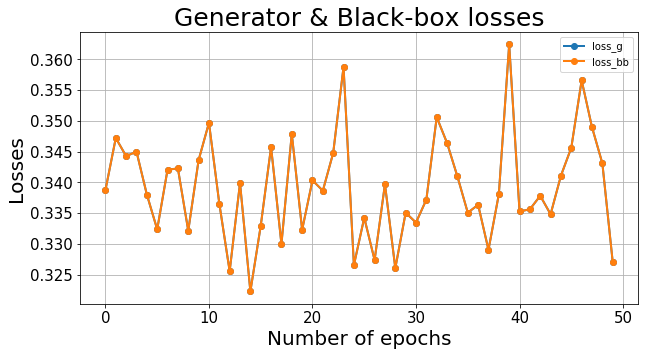

In [8]:
plt.figure(figsize=(10,5))
plt.grid()
plt.title("Generator & Black-box losses", fontsize=25)
plt.plot(hist["loss_g"], '-o', label="loss_g", linewidth=2.0)
plt.plot(hist["loss_bb"], '-o', label="loss_bb", linewidth=2.0)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Number of epochs", fontsize=20)
plt.ylabel("Losses", fontsize=20)
plt.legend(loc='upper right', fontsize=10)
plt.show()